In [1]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import StatePreparation
from qiskit.tools.monitor import job_monitor
import numpy as np
import matplotlib.pyplot as plt

<H1>An Exploration of the Swap Test </H1>

<H3>What does a swap test do? </H3>

A swap test provides an estimate of the amount of overlap between two quantum states.  The quantum states can be single or multi-qubit states.

The similarity_score = an estimate of |<psi|phi>|^2, which is the square of the inner-product of the quantum states |psi> and |phi>.

If two states are equal, the inner product is 1, and if they are orthogonal it is 0.

<H3>How accurate is the estimate?</H3>

The accuracy of this estimate depends on:

<i>1. The number of shots </i>

The estimate can be made arbitrarily more precise by increasing the number of shots.

With O(1/epsilon^2) runs, we expect epsilon of error [1].  

For example, with 1000 runs, epsilon would be ~3% error, and with 10,000 runs, we expect about 1% error, and so on.

Empirically, we examined this for the 1QB test case, whose inner product squared is .919, and found:

<table>
  <tr>
    <th>Number of Shots</th>
    <th>Similarity_Score</th>
      <th>Percent Error (%)</th>  
  </tr>
  <tr>
    <td>10</td>
    <td>1.0</td>
    <td>8.8</td>  
  </tr>
  <tr>
    <td>100</td>
    <td>.82</td>
    <td>11</td>  
  </tr>
  <tr>
    <td>1000</td>  
    <td>.916</td>
    <td><1</td>   
  </tr>
  <tr>    
    <td>10000</td>   
    <td>.912</td>
    <td><1</td>   
  </tr>
 
</table>

We can see that the precision increases when moving from 10 or 100 shots to 1000 or 10000 shots. We don't observe an improvement in running 10k shots rather than 1k.  In this experiment, the estimate given 1000 shots is outperforming our expectation.  


<i>2. The amount of error that occurs in the system during runtime.  We examine gate error in this exploration.  </i>

The more error there is in the gates, then the less chance we are actually running our intended program, and, thus, more chance that our results are off.

<H3> How do we evaluate the swap test in this exploration? </H3>

We use 3 test cases, and run them on a simulator backend with a range of probabilities of depolarizing error; i.e. gate error.

<b>The test cases used: </b>

<i>1QB quantum states, (|psi>, |phi>): </i><br>
([np.sqrt(.3), np.sqrt(.7)], <br>
[np.sqrt(.6), np.sqrt(.4)])

<i>2QB quantum states, (|psi>, |phi>): </i><br>
([np.sqrt(.1), np.sqrt(.2), np.sqrt(.6), np.sqrt(.1)], <br>
 [np.sqrt(0), np.sqrt(.5), np.sqrt(.1), np.sqrt(.4)])

<i>3QB quantum states, (|psi>, |phi>): </i><br>
([np.sqrt(.01), np.sqrt(.1), np.sqrt(.12), np.sqrt(.13), np.sqrt(.04), np.sqrt(0), np.sqrt(.35), np.sqrt(.25)], <br>
 [np.sqrt(0), np.sqrt(.2), np.sqrt(.2), np.sqrt(.1), np.sqrt(.2), np.sqrt(.05), np.sqrt(.05), np.sqrt(.2)])


<b>The probabilities of depolarizing error used:</b> <br>
0 = no error, .01, .025, .05, .10, .25, and .50.

<b>The gates used: </b> <br>

We build a quantum circuit that computes the swap test using Hadamard and CSWAP gates.  

An excellent explanation of the circuit can be found in Hundt's book [2].

The swap test circuit for comparing two 3QB states is as follows:

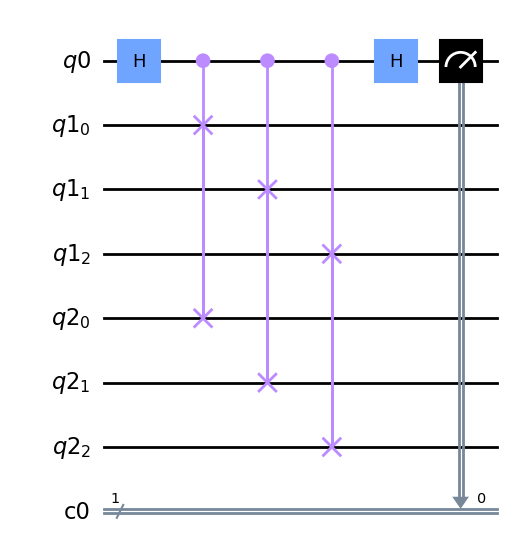

In [2]:
num_qb_per_state = 3

ancilla = QuantumRegister(1)
qr_1 = QuantumRegister(num_qb_per_state)
qr_2 = QuantumRegister(num_qb_per_state)
cl = ClassicalRegister(1)
    
qc = QuantumCircuit(ancilla, qr_1, qr_2, cl)
    
qc.h(0)
qc.cswap(0, 1, 4)
qc.cswap(0, 2, 5)
qc.cswap(0, 3, 6)
        
qc.h(0)
 
qc.measure(0, 0)

qc.draw("mpl")

<H3> How many gates are required for the swap test circuit? </H3>

The number of gates required depends on the size (in qubits) of the quantum states.

<b>Number of Gates Required:</b>
<li>1QB states -> 2 H's, and 1 CSWAP   </li>
<li>2QB states -> 2 H's, and 2 CSWAP's </li>
<li>3QB states -> 2 H's, and 3 CSWAP's </li>
<li>... </li>
<li>nQB states -> 2 H's, and n CSWAP's </li>

The Hadamard gate is a 1QB gate, and the CSWAP is a 3QB gate.

The number of gates required is O(n) in the number of qubits per state, n.  

<H3> How much gate error can be tolerated? </H3>

Based on the runs and plots below, when the depolarizing error is 1%, the similarity_score is similar to no gate error, and when it goes to 2.5%, it drops off a bit, 10% error is too much, and 50% error is killer.  This is true for each test case, whether comparing 1QB states or multi-qubit states (2QB or 3QB).  

<H3> Can we do anything to improve swap test results? </H3>

Theoretically, we can choose to run more shots, as mentioned above, to more precisely estimate the similarity; though, in the 1QB test described above, we didn't observe an improvement when moving from 1000 to 10000 shots.  Both gave results with less than 1% error, which means we got better than expected performance for the 1000 runs case.  

As far as the circuit itself, which must run as intended to achieve the result expected, there is an equivalent circuit that could be used which is less demanding of the hardware, as it requires only 2QB CNOT gates, and not the 3QB CSWAP gates [5].  Gate error tends to increase with the number of qubits involved in the gate (1QB gates have lower error than 2QB gates, for example), so we could try the alternate circuit, to try to reduce gate error.

Something that is not being considered here is measurement error.  The circuit based on H and CSWAP gates requires only 1 measurement, whereas the alternate circuit requires 2n measurements, where n is the number of qubits per state. 

The alternate circuit is given below for the case of 3 qubits per state.  The CCNOT gates after the measurements can be done classically as post-processing of the quantum measurements.

On first glance, at the bottom of this notebook, it appears that the alternate circuit is less accurate in its estimation of the square of the inner product between the two states when there is no error.  As this is the last experiment I have performed in this exploration, it would be worthy of review, to check the method and the code.      

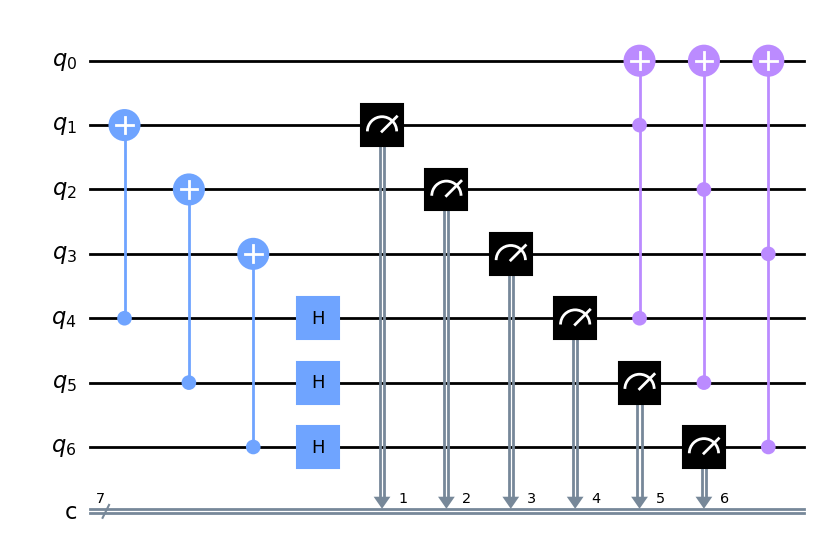

In [3]:
# Alternate Swap Test circuit - uses only 1 and 2 QB gates, avoids needing to use 3 QB gates 
# the 3 ccx gates on the right side of the circuit do not need to be run, but can be computed by 
# classical post-processing of the results

qc = QuantumCircuit(7, 7)
qc.cnot(4,1)
qc.cnot(5,2)
qc.cnot(6,3)
qc.h(4)
qc.h(5)
qc.h(6)
qc.measure(range(1,7), range(1,7))
qc.ccx(1,4,0)
qc.ccx(2,5,0)
qc.ccx(3,6,0)
qc.draw("mpl")

<H3>References:</H3> 
<ol>
    <li>Wikipedia article on "Swap test" </li>
    <li>book: Quantum Computing for Programmers by Robert Hundt</li>
    <li>paper: Quantum Fingerprinting by Buhrman, Cleve, Watrous, de Wolf</li>
    <li>paper: Swap Test with Quantum-Dot Charge Qubits by Li, Barraza, Barrios, Solano, and Albarran-Arriagada
    <li>https://quantumcomputing.stackexchange.com/questions/9775/swap-test-to-calculate-inner-product-with-qiskit-for-multi-qubits-states
</ol>

In [4]:
# ----------------------------------------------------
# Compute Actual Squares of the Inner Products
# ----------------------------------------------------
# Since we have the test cases in hand, that is, we know |psi> and |phi>, we can compute their inner product.

# 1QB case

inner_product = (np.sqrt(.3)*np.sqrt(.6) + np.sqrt(.7)*np.sqrt(.4))**2
print("1QB:", inner_product)

# 2QB case

inner_product = (np.sqrt(.1)*np.sqrt(0) + np.sqrt(.2)*np.sqrt(.5) + np.sqrt(.6)*np.sqrt(.1) + np.sqrt(.1)*np.sqrt(.4))**2
print("2QB:", inner_product)

# 3QB case

inner_product = ((np.sqrt(.01)*np.sqrt(0) + np.sqrt(.1)*np.sqrt(.2) + np.sqrt(.12)*np.sqrt(.2) + np.sqrt(.13)*np.sqrt(.1) +
    np.sqrt(.04)*np.sqrt(0.2) + np.sqrt(0)*np.sqrt(.05) + np.sqrt(.35)*np.sqrt(.05) + np.sqrt(.25)*np.sqrt(.2)))**2
print("3QB:", inner_product)


1QB: 0.908998886412873
2QB: 0.5793900299663589
3QB: 0.7322144721107586


In [5]:
def compute_similarity_score(circuit_results):
    
    counts = circuit_results.get_counts()
    
    num_shots = counts.shots()
    
    if '1' in counts:
        b = counts['1']
    else:
        b = 0
        
    s = 1-(2/num_shots)*(b)

    print(counts)
    print(s)
    
    return s

In [6]:
def create_circuit(state_1, state_2, num_qb_per_state):
    
    ancilla = QuantumRegister(1)
    qr_1 = QuantumRegister(num_qb_per_state)
    qr_2 = QuantumRegister(num_qb_per_state)
    cl = ClassicalRegister(1)
    
    qc = QuantumCircuit(ancilla, qr_1, qr_2, cl)
    
    qc.initialize(state_1, qr_1)
    qc.initialize(state_2, qr_2)
    
    qc.h(0)
    
    for i in range(1, num_qb_per_state + 1):
        qc.cswap(0, i, num_qb_per_state + i)               
        
    qc.h(0)
 
    qc.measure(0, 0)       
    
    return qc

In [7]:
def run_circuit(qc, num_shots=1000, depolarizing_probability=0):
    
    aer_sim = Aer.get_backend('aer_simulator')
    backend = aer_sim
    
    if depolarizing_probability > 0:
        dp_err_1 = depolarizing_error(depolarizing_probability, 1)
        dp_err_2 = depolarizing_error(depolarizing_probability, 2)
        dp_err_3 = depolarizing_error(depolarizing_probability, 3)
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(dp_err_1, ['h'])
        noise_model.add_all_qubit_quantum_error(dp_err_2, ['cx'])
        noise_model.add_all_qubit_quantum_error(dp_err_3, ['cswap'])
        backend.set_options(noise_model=noise_model)

    job = backend.run(qc, shots=num_shots)
    
    job_monitor(job)
    
    result = job.result()
    
    return result

In [8]:
def validate_states(state_1, state_2):
    
    # States to compare must use the same number of qubits
    assert len(state_1) == len(state_2 )
    
    # The state must specify 2**num_qb_per_state amplitudes 
    assert np.log2(len(state_1)).is_integer()

In [9]:
# -----------------------------------------------------------------
# Swap Test on 1 QB States - 1000 shots
# -----------------------------------------------------------------
# Equal states result in a similarity score of 1
# Orthogonal states give a similarity score near 0
# The test case gives a similarity score of 0.92

states_to_compare = [
    ([1, 0], [1, 0]),    # |0>, |0>
    ([0, 1], [0, 1]),    # |1>, |1>
    ([1, 0], [0, 1]),    # |0>, |1>
    ([0, 1], [1, 0]),    # |1>, |0>
    ([np.sqrt(.3), np.sqrt(.7)], 
     [np.sqrt(.6), np.sqrt(.4)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)    

    num_qb_per_state = int(np.log2(len(state_1)))

    qc = create_circuit(state_1, state_2, num_qb_per_state)
    result = run_circuit(qc)

    similarity_scores.append(compute_similarity_score(result))
    
    print(qc)    

print(similarity_scores)

Job Status: job has successfully run
{'0': 1000}
1.0
             ┌───┐          ┌───┐┌─┐
  q3: ───────┤ H ├────────■─┤ H ├┤M├
      ┌──────┴───┴──────┐ │ └───┘└╥┘
  q4: ┤ Initialize(1,0) ├─X───────╫─
      ├─────────────────┤ │       ║ 
  q5: ┤ Initialize(1,0) ├─X───────╫─
      └─────────────────┘         ║ 
c1: 1/════════════════════════════╩═
                                  0 
Job Status: job has successfully run
{'0': 1000}
1.0
             ┌───┐          ┌───┐┌─┐
  q6: ───────┤ H ├────────■─┤ H ├┤M├
      ┌──────┴───┴──────┐ │ └───┘└╥┘
  q7: ┤ Initialize(0,1) ├─X───────╫─
      ├─────────────────┤ │       ║ 
  q8: ┤ Initialize(0,1) ├─X───────╫─
      └─────────────────┘         ║ 
c2: 1/════════════════════════════╩═
                                  0 
Job Status: job has successfully run
{'0': 515, '1': 485}
0.030000000000000027
             ┌───┐          ┌───┐┌─┐
  q9: ───────┤ H ├────────■─┤ H ├┤M├
      ┌──────┴───┴──────┐ │ └───┘└╥┘
 q10: ┤ Initialize(1,0) ├─X───────╫─
 

Text(0.5, 1.0, 'Swap Tests of 1QB States')

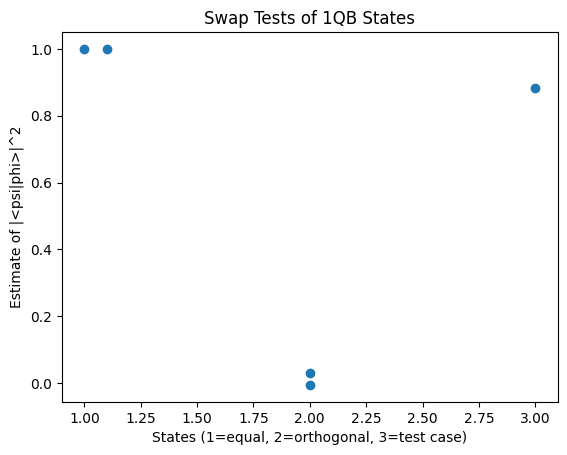

In [10]:
x = (1, 1.1, 2, 2, 3)
plt.scatter(x, similarity_scores)
plt.xlabel('States (1=equal, 2=orthogonal, 3=test case)') 
plt.ylabel('Estimate of |<psi|phi>|^2') 
plt.title('Swap Tests of 1QB States') 

In [11]:
# -----------------------------------------------------------------
# Swap Test on 1 QB States - compare number of shots
# -----------------------------------------------------------------
# 

states_to_compare = [
    ([np.sqrt(.3), np.sqrt(.7)], 
     [np.sqrt(.6), np.sqrt(.4)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)    

    num_qb_per_state = int(np.log2(len(state_1)))

    qc = create_circuit(state_1, state_2, num_qb_per_state)
    
    for num_shots in [10, 100, 1000, 10000]: 
        result = run_circuit(qc, num_shots=num_shots)

        similarity_scores.append(compute_similarity_score(result))

print(similarity_scores)

Job Status: job has successfully run
{'0': 9, '1': 1}
0.8
Job Status: job has successfully run
{'0': 96, '1': 4}
0.92
Job Status: job has successfully run
{'0': 943, '1': 57}
0.886
Job Status: job has successfully run
{'0': 9586, '1': 414}
0.9172
[0.8, 0.92, 0.886, 0.9172]


In [12]:
# -----------------------------------------------------------------
# Swap Test on 2 QB States - 1000 shots
# -----------------------------------------------------------------
# Equal states result in a similarity score of 1
# Orthogonal states give a similarity score near 0
# The test case gives a similarity score of 0.592

states_to_compare = [
    
    ([0, 0, 0, 1], [0, 0, 0, 1]),
    ([1, 0, 0, 0], [1, 0, 0, 0]),

    ([1, 0, 0, 0], [0, 0, 0, 1]),
    ([0, 0, 0, 1], [1, 0, 0, 0]),

    ([np.sqrt(.1), np.sqrt(.2), np.sqrt(.6), np.sqrt(.1)], 
     [np.sqrt(0), np.sqrt(.5), np.sqrt(.1), np.sqrt(.4)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)

    num_qb_per_state = int(np.log2(len(state_1)))
    print("num qb per state:", num_qb_per_state)
    
    qc = create_circuit(state_1, state_2, num_qb_per_state)
    result = run_circuit(qc)

    similarity_scores.append(compute_similarity_score(result))
    
    print(qc)    

print(similarity_scores)

num qb per state: 2
Job Status: job has successfully run
{'0': 1000}
1.0
                ┌───┐                ┌───┐┌─┐
  q21: ─────────┤ H ├───────────■──■─┤ H ├┤M├
       ┌────────┴───┴─────────┐ │  │ └───┘└╥┘
q22_0: ┤0                     ├─X──┼───────╫─
       │  Initialize(0,0,0,1) │ │  │       ║ 
q22_1: ┤1                     ├─┼──X───────╫─
       ├──────────────────────┤ │  │       ║ 
q23_0: ┤0                     ├─X──┼───────╫─
       │  Initialize(0,0,0,1) │    │       ║ 
q23_1: ┤1                     ├────X───────╫─
       └──────────────────────┘            ║ 
 c7: 1/════════════════════════════════════╩═
                                           0 
num qb per state: 2
Job Status: job has successfully run
{'0': 1000}
1.0
                ┌───┐                ┌───┐┌─┐
  q24: ─────────┤ H ├───────────■──■─┤ H ├┤M├
       ┌────────┴───┴─────────┐ │  │ └───┘└╥┘
q25_0: ┤0                     ├─X──┼───────╫─
       │  Initialize(1,0,0,0) │ │  │       ║ 
q25_1: ┤1                 

Text(0.5, 1.0, 'Swap Tests of 2QB States')

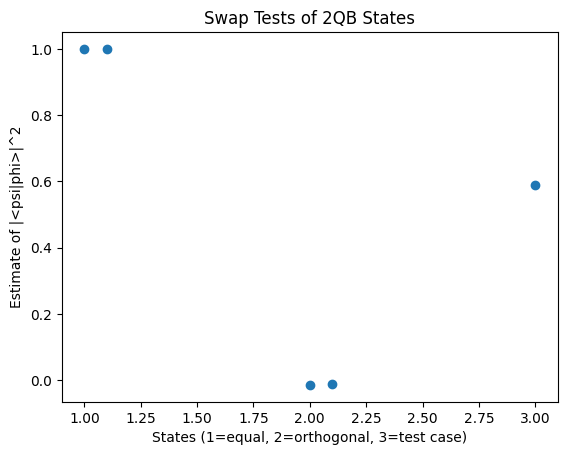

In [13]:
x = (1, 1.1, 2, 2.1, 3)
plt.scatter(x, similarity_scores)
plt.xlabel('States (1=equal, 2=orthogonal, 3=test case)') 
plt.ylabel('Estimate of |<psi|phi>|^2') 
plt.title('Swap Tests of 2QB States')

In [14]:
# -----------------------------------------------------------------
# Swap Test on 3 QB States - 1000 shots
# -----------------------------------------------------------------
# Equal states result in a similarity score of 1
# Orthogonal states give a similarity score near 0
# The test case gives a similarity score of .746

states_to_compare = [
    
    ([0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1]),
    ([1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0]),

    ([1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1]),
    ([0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0]),

    ([np.sqrt(.01), np.sqrt(.1), np.sqrt(.12), np.sqrt(.13), np.sqrt(.04), np.sqrt(0), np.sqrt(.35), np.sqrt(.25)], 
     [np.sqrt(0), np.sqrt(.2), np.sqrt(.2), np.sqrt(.1), np.sqrt(.2), np.sqrt(.05), np.sqrt(.05), np.sqrt(.2)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)

    num_qb_per_state = int(np.log2(len(state_1)))
    print("num qb per state:", num_qb_per_state)
    
    qc = create_circuit(state_1, state_2, num_qb_per_state)
    result = run_circuit(qc)

    similarity_scores.append(compute_similarity_score(result))
    
    print(qc)    

print(similarity_scores)

num qb per state: 3
Job Status: job has successfully run
{'0': 1000}
1.0
                    ┌───┐                       ┌───┐┌─┐
  q36: ─────────────┤ H ├───────────────■──■──■─┤ H ├┤M├
       ┌────────────┴───┴─────────────┐ │  │  │ └───┘└╥┘
q37_0: ┤0                             ├─X──┼──┼───────╫─
       │                              │ │  │  │       ║ 
q37_1: ┤1 Initialize(0,0,0,0,0,0,0,1) ├─┼──X──┼───────╫─
       │                              │ │  │  │       ║ 
q37_2: ┤2                             ├─┼──┼──X───────╫─
       ├──────────────────────────────┤ │  │  │       ║ 
q38_0: ┤0                             ├─X──┼──┼───────╫─
       │                              │    │  │       ║ 
q38_1: ┤1 Initialize(0,0,0,0,0,0,0,1) ├────X──┼───────╫─
       │                              │       │       ║ 
q38_2: ┤2                             ├───────X───────╫─
       └──────────────────────────────┘               ║ 
c12: 1/═══════════════════════════════════════════════╩═
               

Text(0.5, 1.0, 'Swap Tests of 3QB States')

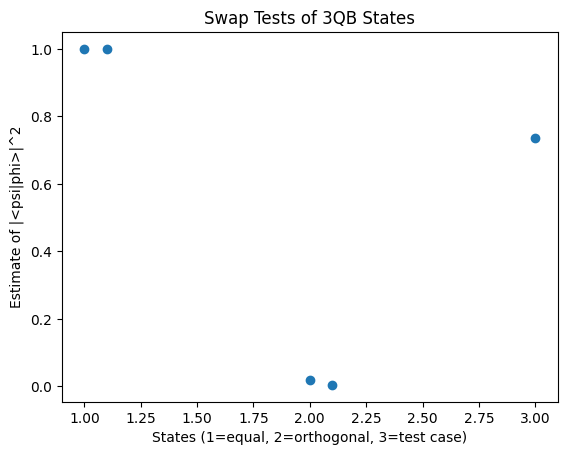

In [15]:
x = (1, 1.1, 2, 2.1, 3)
plt.scatter(x, similarity_scores)
plt.xlabel('States (1=equal, 2=orthogonal, 3=test case)') 
plt.ylabel('Estimate of |<psi|phi>|^2') 
plt.title('Swap Tests of 3QB States')

In [16]:
## Examine running the swap test with a noisy backend
## 1QB State Comparisons

states_to_compare = [
    ([np.sqrt(.3), np.sqrt(.7)], 
     [np.sqrt(.6), np.sqrt(.4)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)    

    num_qb_per_state = int(np.log2(len(state_1)))

    qc = create_circuit(state_1, state_2, num_qb_per_state)

    noise_levels = [0, .01, .025, .05, .10, .25, .50]

    for noise_level in noise_levels:
        result = run_circuit(qc, depolarizing_probability=noise_level)

        similarity_scores.append(compute_similarity_score(result))
    
    print(qc)    

print(similarity_scores)

Job Status: job has successfully run
{'0': 951, '1': 49}
0.902
Job Status: job has successfully run
{'0': 938, '1': 62}
0.876
Job Status: job has successfully run
{'0': 930, '1': 70}
0.86
Job Status: job has successfully run
{'0': 896, '1': 104}
0.792
Job Status: job has successfully run
{'0': 818, '1': 182}
0.636
Job Status: job has successfully run
{'0': 702, '1': 298}
0.404
Job Status: job has successfully run
{'0': 544, '1': 456}
0.08799999999999997
                    ┌───┐                ┌───┐┌─┐
  q51: ─────────────┤ H ├──────────────■─┤ H ├┤M├
       ┌────────────┴───┴────────────┐ │ └───┘└╥┘
  q52: ┤ Initialize(0.54772,0.83666) ├─X───────╫─
       └┬────────────────────────────┤ │       ║ 
  q53: ─┤ Initialize(0.7746,0.63246) ├─X───────╫─
        └────────────────────────────┘         ║ 
c17: 1/════════════════════════════════════════╩═
                                               0 
[0.902, 0.876, 0.86, 0.792, 0.636, 0.404, 0.08799999999999997]


Text(0.5, 1.0, 'Swap Tests of 1QB State')

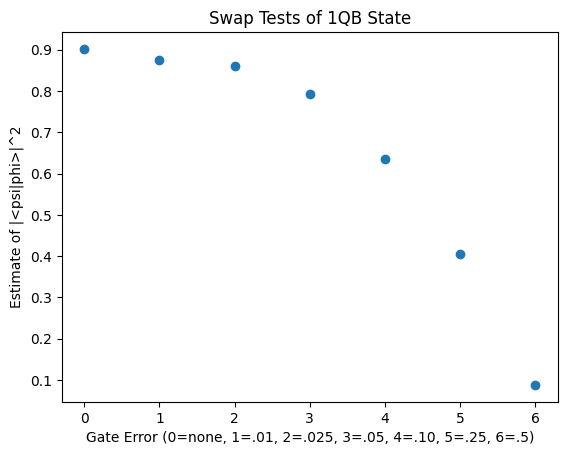

In [17]:
x = (0, 1, 2, 3, 4, 5, 6)
plt.scatter(x, similarity_scores)
plt.xlabel('Gate Error (0=none, 1=.01, 2=.025, 3=.05, 4=.10, 5=.25, 6=.5)') 
plt.ylabel('Estimate of |<psi|phi>|^2') 
plt.title('Swap Tests of 1QB State')

In [18]:
## Examine running the swap test with a noisy backend
## 2QB State Comparisons

states_to_compare = [
    ([np.sqrt(.1), np.sqrt(.2), np.sqrt(.6), np.sqrt(.1)], 
     [np.sqrt(0), np.sqrt(.5), np.sqrt(.1), np.sqrt(.4)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)    

    num_qb_per_state = int(np.log2(len(state_1)))

    qc = create_circuit(state_1, state_2, num_qb_per_state)

    noise_levels = [0, .01, .025, .05, .10, .25, .50]

    for noise_level in noise_levels:
        result = run_circuit(qc, depolarizing_probability=noise_level)

        similarity_scores.append(compute_similarity_score(result))
    
    print(qc)    

print(similarity_scores)

Job Status: job has successfully run
{'0': 798, '1': 202}
0.596
Job Status: job has successfully run
{'0': 790, '1': 210}
0.5800000000000001
Job Status: job has successfully run
{'1': 241, '0': 759}
0.518
Job Status: job has successfully run
{'0': 725, '1': 275}
0.44999999999999996
Job Status: job has successfully run
{'0': 709, '1': 291}
0.41800000000000004
Job Status: job has successfully run
{'0': 572, '1': 428}
0.14400000000000002
Job Status: job has successfully run
{'1': 493, '0': 507}
0.014000000000000012
                            ┌───┐                           ┌───┐┌─┐
  q54: ─────────────────────┤ H ├──────────────────────■──■─┤ H ├┤M├
       ┌────────────────────┴───┴────────────────────┐ │  │ └───┘└╥┘
q55_0: ┤0                                            ├─X──┼───────╫─
       │  Initialize(0.31623,0.44721,0.7746,0.31623) │ │  │       ║ 
q55_1: ┤1                                            ├─┼──X───────╫─
       └──┬────────────────────────────────────────┬─┘ │  │       ║ 

Text(0.5, 1.0, 'Swap Tests of 2QB State')

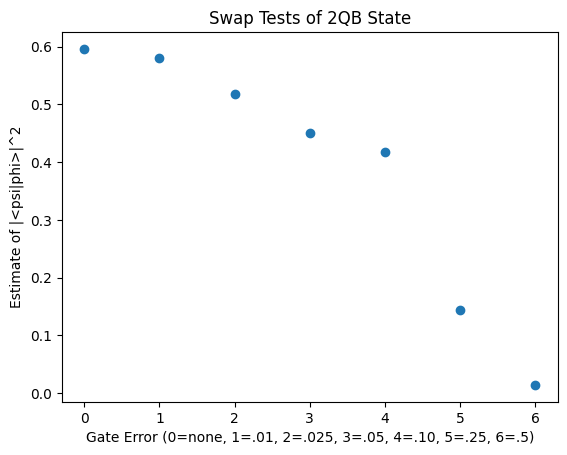

In [19]:
x = (0, 1, 2, 3, 4, 5, 6)
plt.scatter(x, similarity_scores)
plt.xlabel('Gate Error (0=none, 1=.01, 2=.025, 3=.05, 4=.10, 5=.25, 6=.5)') 
plt.ylabel('Estimate of |<psi|phi>|^2') 
plt.title('Swap Tests of 2QB State')

In [20]:
## Examine running the swap test with a noisy backend
## 3QB State Comparisons

states_to_compare = [
    ([np.sqrt(.01), np.sqrt(.1), np.sqrt(.12), np.sqrt(.13), np.sqrt(.04), np.sqrt(0), np.sqrt(.35), np.sqrt(.25)], 
     [np.sqrt(0), np.sqrt(.2), np.sqrt(.2), np.sqrt(.1), np.sqrt(.2), np.sqrt(.05), np.sqrt(.05), np.sqrt(.2)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)    

    num_qb_per_state = int(np.log2(len(state_1)))

    qc = create_circuit(state_1, state_2, num_qb_per_state)

    noise_levels = [0, .01, .025, .05, .10, .25, .50]

    for noise_level in noise_levels:
        result = run_circuit(qc, depolarizing_probability=noise_level)

        similarity_scores.append(compute_similarity_score(result))
    
    print(qc)    

print(similarity_scores)

Job Status: job has successfully run
{'0': 879, '1': 121}
0.758
Job Status: job has successfully run
{'0': 848, '1': 152}
0.696
Job Status: job has successfully run
{'0': 822, '1': 178}
0.644
Job Status: job has successfully run
{'0': 776, '1': 224}
0.552
Job Status: job has successfully run
{'0': 727, '1': 273}
0.45399999999999996
Job Status: job has successfully run
{'1': 432, '0': 568}
0.136
Job Status: job has successfully run
{'0': 502, '1': 498}
0.0040000000000000036
       »
  q57: »
       »
q58_0: »
       »
q58_1: »
       »
q58_2: »
       »
q59_0: »
       »
q59_1: »
       »
q59_2: »
       »
c19: 1/»
       »
«                                         ┌───┐                                   »
«  q57: ──────────────────────────────────┤ H ├───────────────────────────────────»
«             ┌───────────────────────────┴───┴────────────────────────────┐      »
«q58_0: ──────┤0                                                           ├──────»
«             │                  

Text(0.5, 1.0, 'Swap Tests of 3QB State')

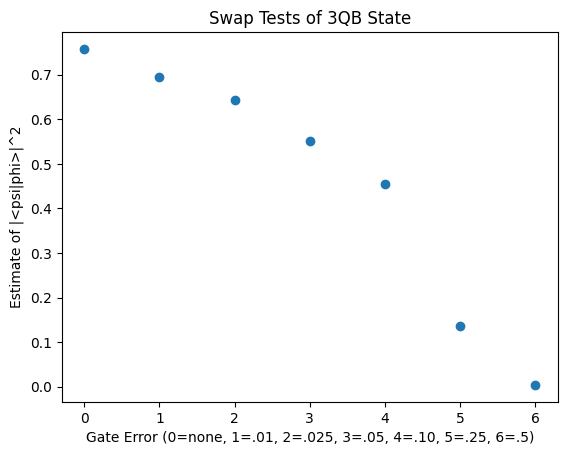

In [21]:
x = (0, 1, 2, 3, 4, 5, 6)
plt.scatter(x, similarity_scores)
plt.xlabel('Gate Error (0=none, 1=.01, 2=.025, 3=.05, 4=.10, 5=.25, 6=.5)') 
plt.ylabel('Estimate of |<psi|phi>|^2') 
plt.title('Swap Tests of 3QB State')

In [22]:
def create_alternate_circuit(state_1, state_2, num_qb_per_state):
    
    if num_qb_per_state != 3:
        return None
    
    ancilla = QuantumRegister(1)
    qr_1 = QuantumRegister(num_qb_per_state)
    qr_2 = QuantumRegister(num_qb_per_state)
    cl = ClassicalRegister(2*num_qb_per_state + 1)
    
    qc = QuantumCircuit(ancilla, qr_1, qr_2, cl)
    
    qc.initialize(state_1, qr_1)
    qc.initialize(state_2, qr_2)
    
    qc.cx(4,1)
    qc.cx(5,2)
    qc.cx(6,3)
    qc.h(4)
    qc.h(5)
    qc.h(6)
    
    qc.measure(range(1,7), range(1,7))   
    
    return qc
    

In [23]:
def odd_number_of_one_one_pairs(s):
    
    num_one_one_pairs = 0
    
    for i in range(0,3):

        if s[i] == "1" and s[i+3] == "1":
            
            num_one_one_pairs += 1

    odd_num_one_one_pairs = False if num_one_one_pairs % 2 == 0 else True
    
    return odd_num_one_one_pairs
            

In [24]:
def compute_similarity_score_for_alternate_circuit(circuit_results):
    
    counts = circuit_results.get_counts()
    
    num_shots = counts.shots()
    
    b = 0
    for measurement in counts.keys():
        if odd_number_of_one_one_pairs(measurement):
            b += counts[measurement]
        
    s = 1-(2/num_shots)*(b)

    print(counts)
    print(s)
    
    return s
    

In [25]:
# Test Function
assert(odd_number_of_one_one_pairs("111000") == False)
assert(odd_number_of_one_one_pairs("111111") == True)
assert(odd_number_of_one_one_pairs("100100") == True)
assert(odd_number_of_one_one_pairs("111110") == False)

In [26]:
## Use the Alternate Circuit and classical post-processing to perform the swap test
## 3QB State Comparisons, with a noisy backend

states_to_compare = [
    ([np.sqrt(.01), np.sqrt(.1), np.sqrt(.12), np.sqrt(.13), np.sqrt(.04), np.sqrt(0), np.sqrt(.35), np.sqrt(.25)], 
     [np.sqrt(0), np.sqrt(.2), np.sqrt(.2), np.sqrt(.1), np.sqrt(.2), np.sqrt(.05), np.sqrt(.05), np.sqrt(.2)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)    

    num_qb_per_state = int(np.log2(len(state_1)))

    qc = create_alternate_circuit(state_1, state_2, num_qb_per_state)

    noise_levels = [0, .01, .025, .05, .10, .25, .50]

    for noise_level in noise_levels:
        result = run_circuit(qc, depolarizing_probability=noise_level)

        similarity_scores.append(compute_similarity_score_for_alternate_circuit(result))
    
    print(qc)    

print(similarity_scores)

Job Status: job has successfully run
{'1111110': 11, '0000110': 77, '0001000': 84, '1000110': 1, '1111100': 30, '0000000': 88, '1110000': 20, '0001100': 65, '1000100': 1, '1111010': 12, '0000010': 63, '1001100': 2, '1110110': 21, '0001110': 53, '1011010': 2, '1101000': 20, '0111110': 1, '0100010': 41, '0101000': 32, '1010100': 15, '1110010': 3, '0001010': 111, '0010010': 6, '1000010': 3, '0000100': 68, '0110110': 2, '0101010': 23, '0101100': 6, '0011100': 5, '1100110': 3, '0100000': 24, '1011110': 31, '0111100': 3, '0100100': 11, '1001000': 1, '1100010': 3, '1011000': 6, '1101010': 6, '1111000': 2, '1100100': 10, '0101110': 7, '0011110': 5, '1100000': 5, '1010010': 6, '1010110': 1, '0100110': 4, '1001010': 1, '1110100': 2, '0010000': 1, '1011100': 1, '1010000': 1}
0.766
Job Status: job has successfully run
{'0101100': 8, '1000110': 3, '1111100': 22, '0000000': 88, '0001000': 77, '1000010': 2, '0000100': 57, '1100000': 6, '0011110': 7, '1001100': 1, '0001110': 44, '1110110': 22, '011111

Text(0.5, 1.0, 'Swap Tests of 3QB State Using Alternate Circuit')

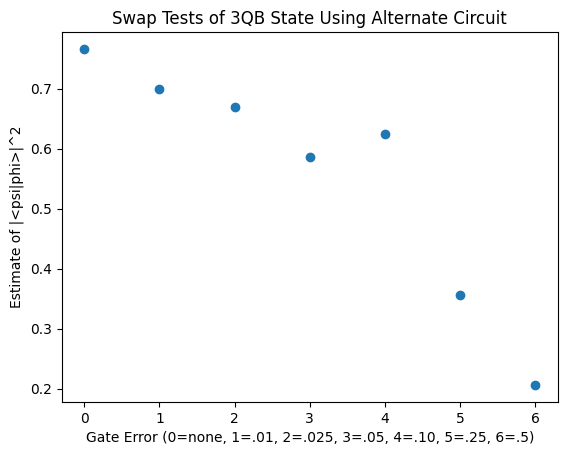

In [27]:
x = (0, 1, 2, 3, 4, 5, 6)
plt.scatter(x, similarity_scores)
plt.xlabel('Gate Error (0=none, 1=.01, 2=.025, 3=.05, 4=.10, 5=.25, 6=.5)') 
plt.ylabel('Estimate of |<psi|phi>|^2') 
plt.title('Swap Tests of 3QB State Using Alternate Circuit')